In [1]:
from metrics import (
    SquaredError, 
    
    FunctionClassError, 
    FCErrorQuadrants,
    FCErrorOrthogonal,
    FCErrorSeenPoints,
)
from metrics.utils import post_process, average_evals, plot_comparison_2_models, load_model
from function_classes.wrappers import (
    ScaledXRegression,
    ScaledYRegression,
    NoisyXRegression,
    NoisyYRegression,
)

from models.linear import LeastSquaresModel, LassoModel
from models.zero_model import ZeroModel

from models.transformer import GPT2, Llama

from function_classes.linear import LinearRegression, SparseLinearRegression

import matplotlib.pyplot as plt
from torch.distributions import MultivariateNormal
import torch

/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/opt/conda/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [3]:
B_SIZE, SEQ_LEN, X_DIM, Y_DIM = 128, 41, 20, 1
X_SHAPE = torch.Size([B_SIZE, SEQ_LEN, X_DIM])
Y_SHAPE = torch.Size([B_SIZE, SEQ_LEN, Y_DIM])

MODELS = [LeastSquaresModel(x_dim=X_DIM), ZeroModel(x_dim=X_DIM)]#[LassoModel(alpha=0.01, x_dim=X_DIM), LassoModel(alpha=0.02, x_dim=X_DIM), LassoModel(alpha=0.04, x_dim=X_DIM), LassoModel(alpha=0.08, x_dim=X_DIM)]

SCALES: list[float] = [0.125, 0.25, 0.5, 2., 4., 8.]
NOISE_LEVELS: list[float] = [0.0625, 0.125, 0.25, 0.5, 1.]

METRIC = SquaredError()

In [4]:
x_dist = MultivariateNormal(torch.zeros(X_SHAPE), torch.eye(X_DIM)) #batch size, sequence_length, x_dim

base_fc = LinearRegression(x_dist, y_dim=Y_DIM)

bench = FunctionClassError(METRIC, function_class=base_fc)

100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


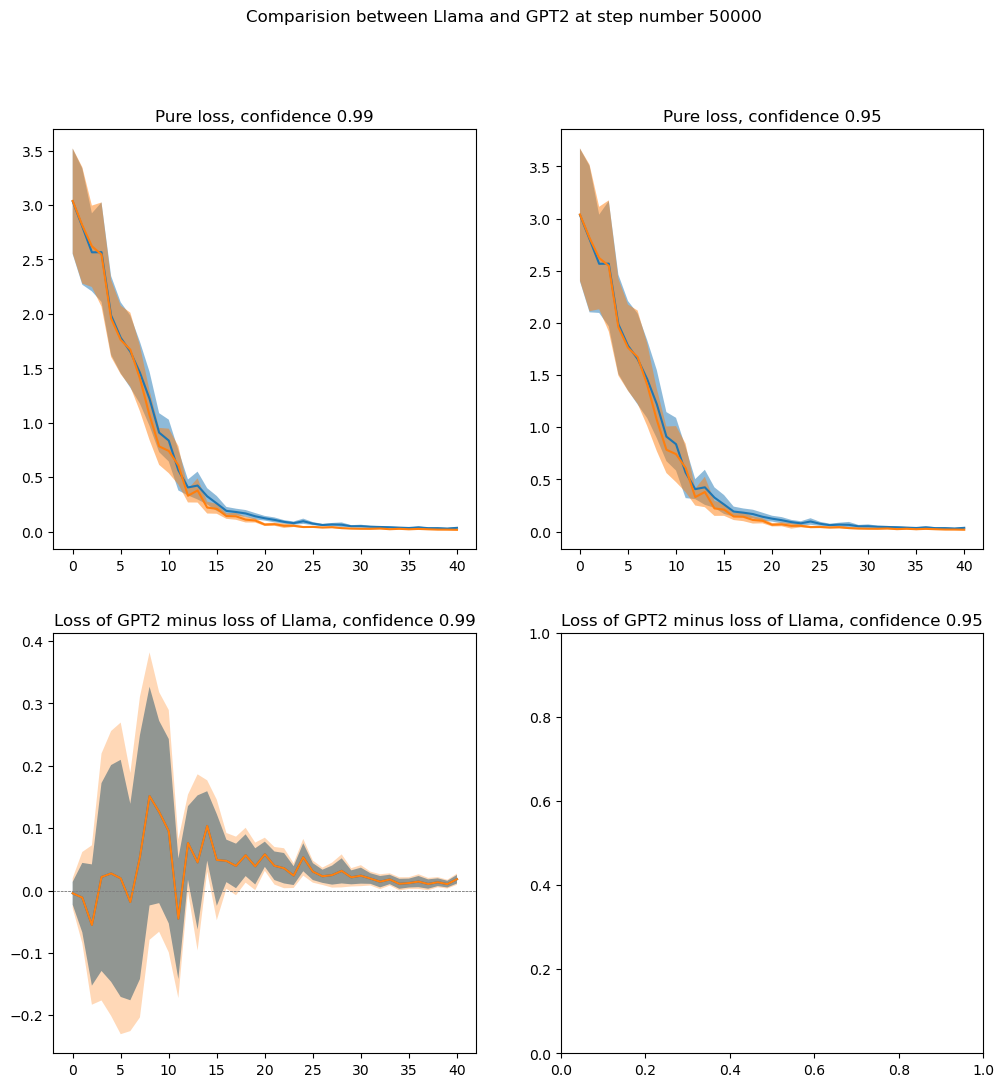

KeyboardInterrupt: 

In [18]:
for size in [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000, 450000, 500000]:
    MODELS=[]

    Model1=load_model("stored_models/Sparse_linear/gpt2/checkpoint_"+str(size)+ " (3)", GPT2(x_dim=20, n_positions=101,  n_embd=256, n_layer=12, n_head=8))
    Model2=load_model("stored_models/Sparse_linear/Llama/checkpoint_"+str(size)+" (2)", Llama(x_dim=20, n_positions=101,  n_embd=256, n_layer=12, n_head=8))
    MODELS=[Model1.cuda(), Model2.cuda()]
    Model1=None
    Model2=None
    errs = average_evals(MODELS, bench, 2, 2)#bench.evaluate(MODELS, num_batches=64, perfect_model=LeastSquaresModel(x_dim=X_DIM))
    plot_comparison_2_models(MODELS, ["GPT2", "Llama"], errs, title=f"Comparision between Llama and GPT2 at step number {size}")

In [ ]:
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))

dict_keys(['accuracy', 'std', 'std_mean', 'max', 'min', 'confidence_0.01_upper', 'confidence_0.01_lower', 'confidence_0.05_upper', 'confidence_0.05_lower', 'quantile_0.05', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75', 'quantile_0.95'])
dict_keys(['accuracy', 'std', 'std_mean', 'max', 'min', 'confidence_0.01_upper', 'confidence_0.01_lower', 'confidence_0.05_upper', 'confidence_0.05_lower', 'quantile_0.05', 'quantile_0.25', 'quantile_0.5', 'quantile_0.75', 'quantile_0.95'])


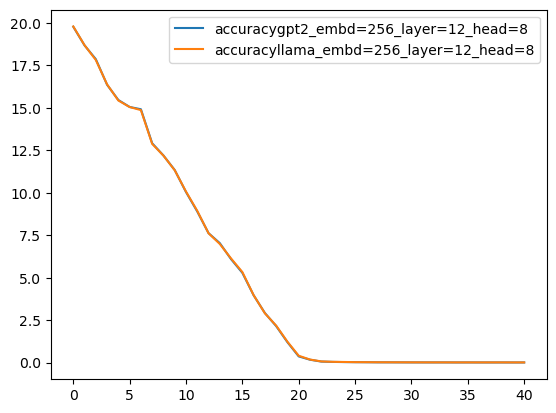

In [ ]:
for model, results in zip(MODELS, values):
    print(results.keys())
    plt.plot(results["accuracy"][:, 0], label=model.name)
plt.legend()
plt.show()

In [ ]:
scaled_x_fcs = [
    ScaledXRegression(scale, base_fc)
    for scale in SCALES
]
scaled_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_x_fcs]

scaled_y_fcs = [
    ScaledYRegression(scale, base_fc)
    for scale in SCALES
]
scaled_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in scaled_y_fcs]

noisy_x_fcs = [
    NoisyXRegression(
        MultivariateNormal(
            torch.zeros(X_SHAPE), 
            noise_level * torch.eye(X_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_in_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_x_fcs]

noisy_y_fcs = [
    NoisyYRegression(
        MultivariateNormal(
            torch.zeros(Y_SHAPE), 
            noise_level * torch.eye(Y_DIM)
        ),
        base_fc 
    )
    for noise_level in NOISE_LEVELS
]
noise_out_benches = [FunctionClassError(METRIC, function_class=fc) for fc in noisy_y_fcs]

In [ ]:
for b in scaled_in_benches:
    errs = b.evaluate(MODELS, num_batches=4)
    values = list(post_process(errs))
    for model, results in zip(MODELS, values):
        plt.title(f"Errors for X scaled by {b.fn_cls._scale}")  # pyright: ignore[reportAttributeAccessIssue]
        plt.plot(results["accuracy"][:, 0], label="accuracy")
        plt.plot(results["confidence_0.99_upper"][:, 0])
        plt.plot(results["confidence_0.99_lower"][:, 0])
        plt.legend()
        plt.show()
        break

AttributeError: 'FunctionClassError' object has no attribute 'fn_cls'

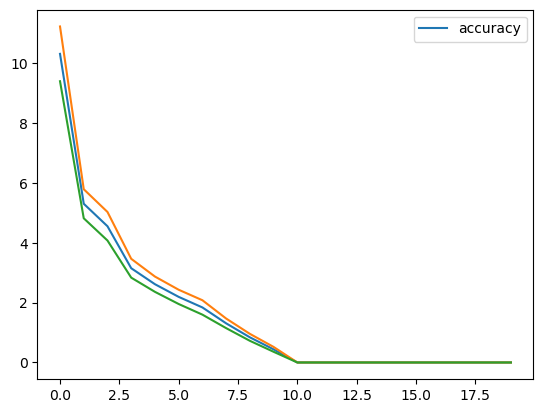

In [ ]:
bench = FCErrorQuadrants(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot(results["accuracy"][:, 0], label="accuracy")
    plt.plot(results["confidence_0.99_upper"][:, 0])
    plt.plot(results["confidence_0.99_lower"][:, 0])
    plt.legend()
    plt.show()
    break


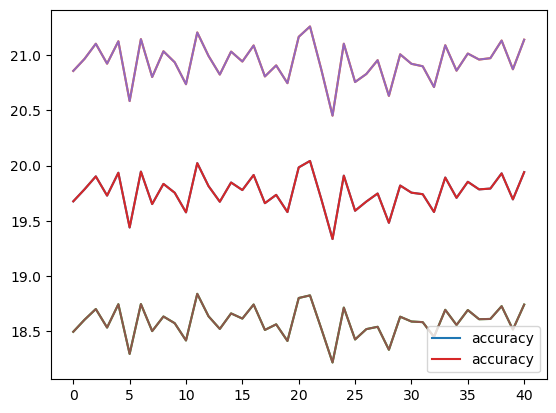

In [9]:
bench = FCErrorOrthogonal(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=32)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot(results["accuracy"][:, 0], label="accuracy")
    plt.plot(results["confidence_0.99_upper"][:, 0])
    plt.plot(results["confidence_0.99_lower"][:, 0])
plt.legend()
plt.show()

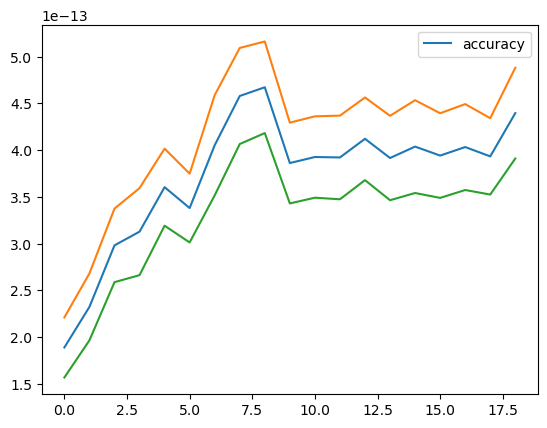

In [ ]:
bench = FCErrorSeenPoints(METRIC, base_fc)
errs = bench.evaluate(MODELS, num_batches=4)
values = list(post_process(errs))
for model, results in zip(MODELS, values):
    plt.plot(results["accuracy"][:, 0], label="accuracy")
    plt.plot(results["confidence_0.99_upper"][:, 0])
    plt.plot(results["confidence_0.99_lower"][:, 0])
    plt.legend()
    plt.show()
    break